In [17]:
import numpy as np
import seaborn as sn
import matplotlib.pylab as plt
import pandas as pd
import urllib3


def open_matrix(filename='outfile_kuba.txt'):
    with open(filename, 'r') as f:
        l = [[int(float(num)) for num in line.split(' ')] for line in f]

    return l

confusion_matrix = open_matrix()



def get_coco_labels():
    http = urllib3.PoolManager()
    r = http.request('GET', 'https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt')
    dane = r.data.decode('UTF-8')
    my_data = dane.split('\n')

    coco = {i+1: my_data[i] for i in range(0,len(my_data))}
    coco.pop(91) # remove hairbrush
    return coco


In [18]:
tmp = []
for row in confusion_matrix:
    normalized_row = []
    for value in row:
        normalized_row.append(value/(sum(row)+1))
    tmp.append(normalized_row)

In [19]:
df_cm = pd.DataFrame(tmp, range(91), range(91))
plt.figure(figsize=(91*4,91*4))
sn.set(font_scale=1) # for label size
sn.heatmap(tmp, annot=True, annot_kws={"size": 4}) # font size
plt.show()


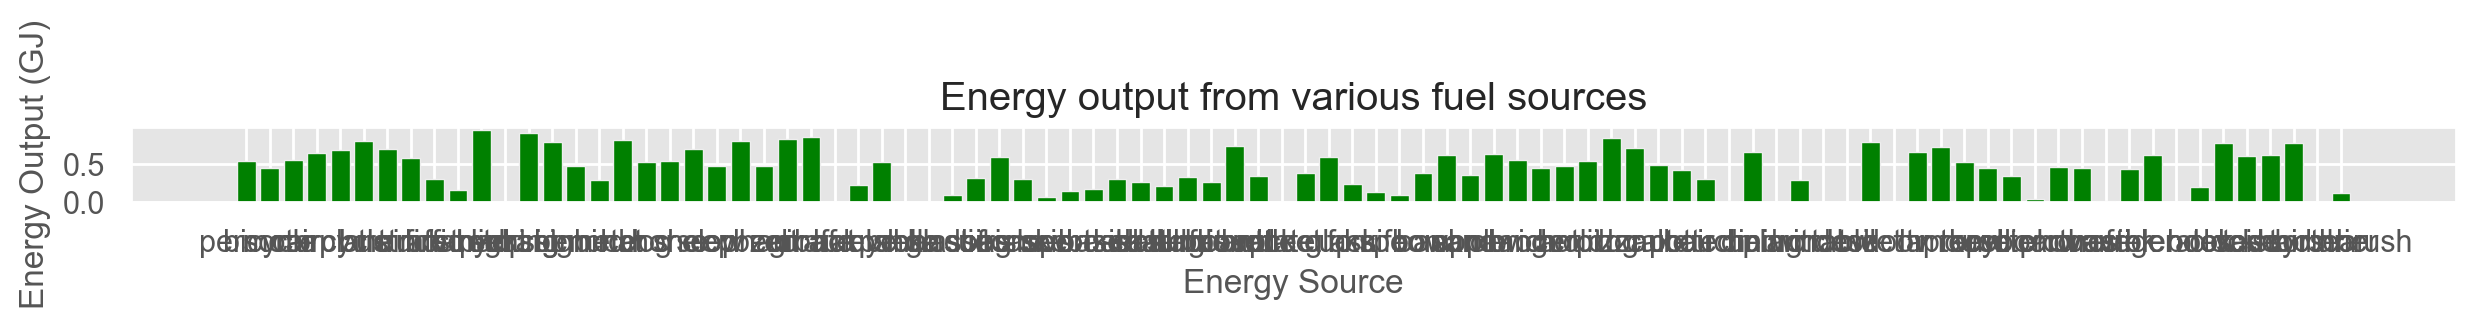

In [20]:
diag = [ tmp[i][i] for i in range(len(tmp)) ]
diag = diag[:-1]
plt.style.use('ggplot')
coco = get_coco_labels().values()

energy = [5, 6, 15, 22, 24, 8]
x_pos = [i for i, _ in enumerate(coco)]

plt.figure(figsize=(15, 0.5), dpi=200)

plt.bar(x_pos, diag, color='green')
plt.xlabel("Energy Source")
plt.ylabel("Energy Output (GJ)")
plt.title("Energy output from various fuel sources")

plt.xticks(x_pos, coco)

plt.show()


(0.0, 90.0)

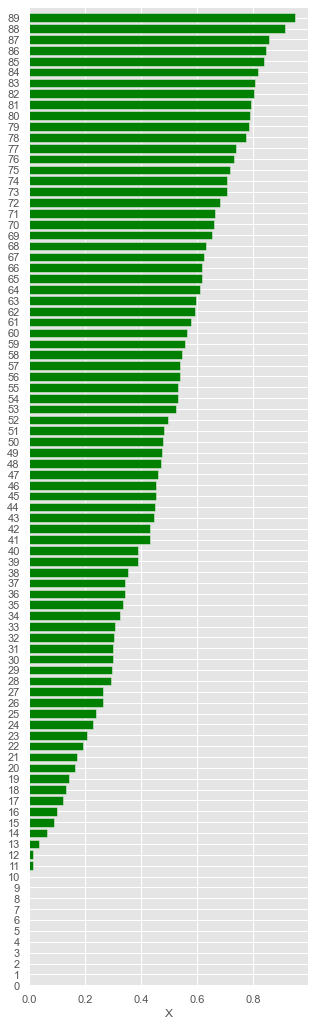

In [21]:
diag = [ tmp[i][i] for i in range(len(tmp)) ]
diag = diag[:-1]
coco = get_coco_labels().values()
x_pos = [i for i, _ in enumerate(coco)]

n = 500

fig, ax = plt.subplots(figsize=(5,90//5))  # Changing figsize depending upon data

# Example data
y_pos = np.arange(n)
y_pos = np.arange(len(x_pos))
performance = 3 + 10 * np.random.rand(n)

ax.barh(y_pos, np.sort(diag), align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels([str(x) for x in y_pos])
ax.set_xlabel('X')
ax.set_ylim(0, 90)     # Manage y-axis properly


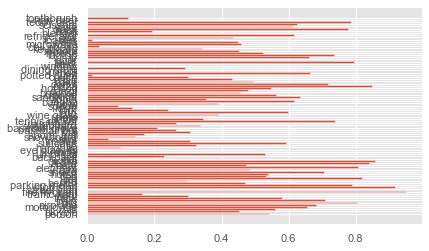

In [22]:
diag = [ tmp[i][i] for i in range(len(tmp)) ]
diag = diag[:-1]

coco = list(get_coco_labels().values())
# x = np.array(coco)
#y = np.array[diag]

plt.barh(coco, diag)
plt.show()



<ipython-input-10-bf2e1d6d0b00>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename, papertype='a2')


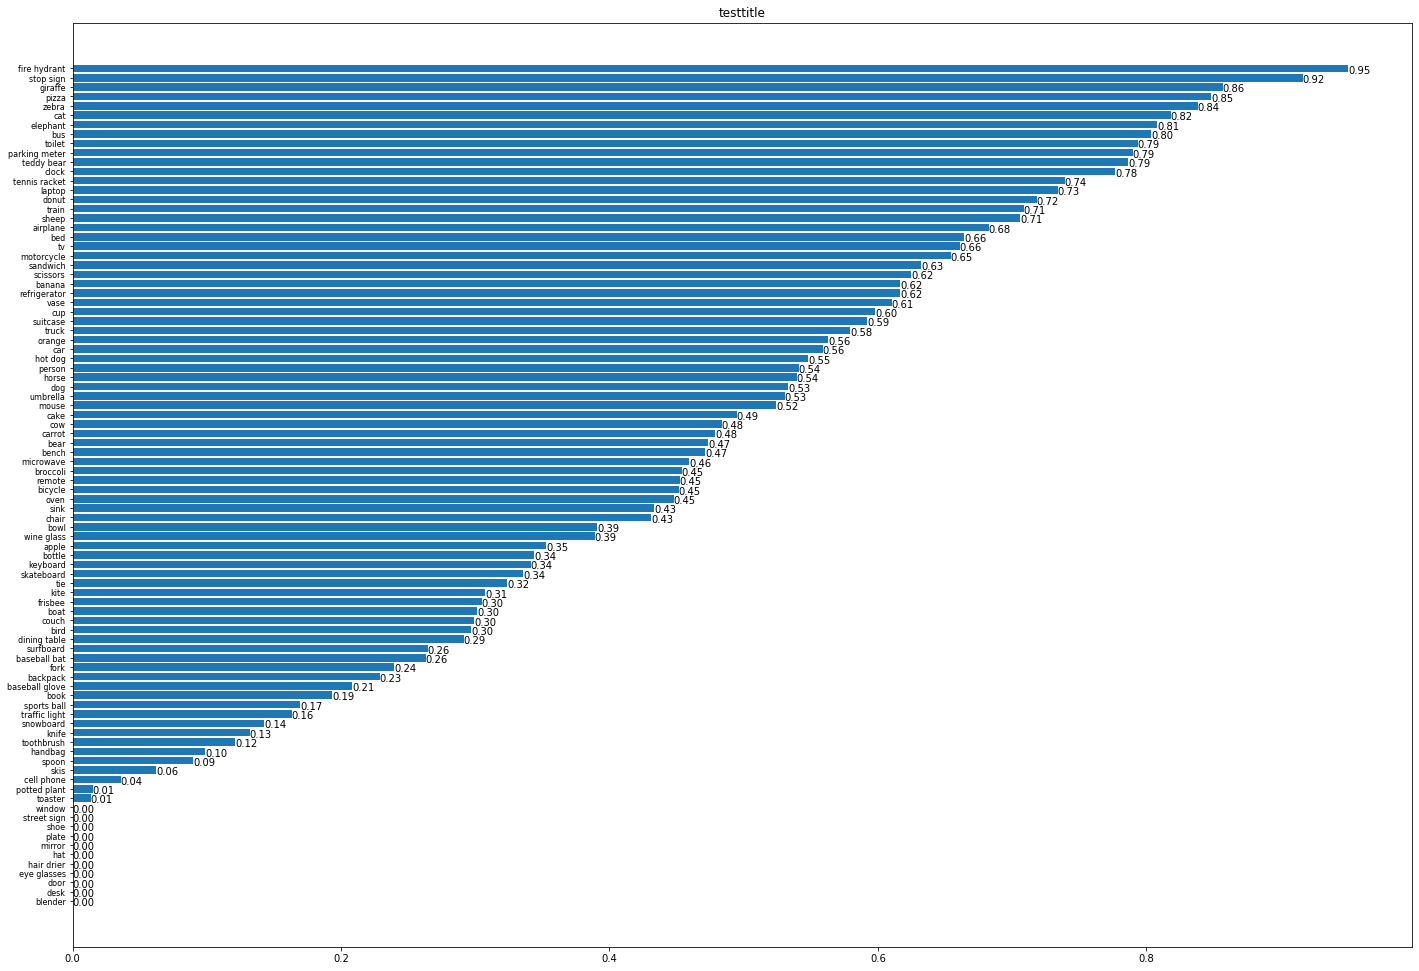

In [10]:

def draw_bar_chart(values, labels, title, filename):
    _values, _labels = zip(*sorted(zip(values, labels)))
    positions = np.arange(len(_values)) + 0.5
    plt.figure(num=None, figsize=(24, 17))
    plt.barh(positions, _values, align='center')

    plt.yticks(positions, _labels)
    plt.tick_params(axis='y', labelsize=8)

    for index, v in enumerate(_values):
        plt.text(v, index, "{:.2f}".format(v))

    plt.xlabel('')
    plt.title(title)
    # ax = plt.axes()
    # print(ax)
    # ax.xaxis.grid(True)
    plt.savefig(filename, papertype='a2')



diag = [ tmp[i][i] for i in range(len(tmp)) ]
diag = diag[:-1]

coco = list(get_coco_labels().values())


draw_bar_chart(diag, coco, 'testtitle','fun_test.pdf');



# # values = diag
# # labels = coco
# values, labels = zip(*sorted(zip(diag, coco)))
#
# positions = np.arange(len(values)) + 0.5
# plt.figure(num=None, figsize=(24, 17))
# plt.barh(positions, values, align='center')
# plt.yticks(positions, labels)
# plt.tick_params(axis='y', labelsize=8)
# plt.xlabel('')
# plt.title('Detected/all detections')
# ax = plt.axes()
# ax.xaxis.grid(True)
# plt.savefig('foo.pdf', papertype='a2')